<a href="https://colab.research.google.com/github/aandrijana/ColorizeIMG/blob/main/ColorizeIMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the Image Colorization dataset from Kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

import os
import shutil

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

Saving kaggle.json to kaggle.json


In [ ]:
!pip install kaggle
!kaggle datasets list

In [ ]:
!kaggle datasets download -d shravankumar9892/image-colorization

Dataset URL: https://www.kaggle.com/datasets/shravankumar9892/image-colorization
License(s): CC0-1.0


In [ ]:
import zipfile

with zipfile.ZipFile("image-colorization.zip", "r") as zip_ref:
    zip_ref.extractall("image_colorization_data")

In [ ]:
import os

# List files in the extracted directory
os.listdir("image_colorization_data")

# Data exploration

### Shape:

In [ ]:
import numpy as np
l_channel = np.load("image_colorization_data/l/gray_scale.npy")
ab1= np.load("image_colorization_data/ab/ab/ab1.npy")
print("Gray image shape:", l_channel.shape)
print("AB image shape:", ab1.shape)

Gray image shape: (25000, 224, 224)
AB image shape: (10000, 224, 224, 2)


### Loading one picture and printing it's grayscale, LAB and colorized version

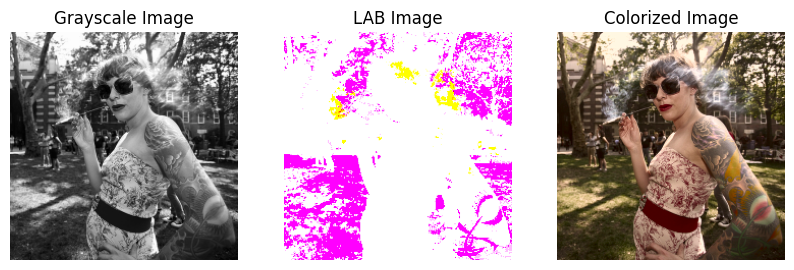

In [ ]:
import cv2
import matplotlib.pyplot as plt
# Load grayscale L channel
gray_images = np.load("image_colorization_data/l/gray_scale.npy")  # Shape: (N, 224, 224)

# Load AB files
ab1 = np.load("image_colorization_data/ab/ab/ab1.npy")
ab2 = np.load("image_colorization_data/ab/ab/ab2.npy")
ab3 = np.load("image_colorization_data/ab/ab/ab3.npy")
index = 0


if index < ab1.shape[0]:
    ab = ab1[index]
elif index < ab1.shape[0] + ab2.shape[0]:
    ab = ab2[index - ab1.shape[0]]
elif index < ab1.shape[0] + ab2.shape[0] + ab3.shape[0]:
    ab = ab3[index - ab1.shape[0] - ab2.shape[0]]
else:
    raise ValueError("Index out of range for available AB data.")

l_channel = gray_images[index]
l_channel = (l_channel / 255.0) * 100  #In LAB color space, L values range from 0 to 100
# Fix AB scaling from [20,226] → [-128,127]
ab = ((ab - 20) / (226 - 20)) * (127 - (-128)) + (-128)

# Merge into LAB format
lab_image = np.dstack((l_channel, ab))

# Convert LAB to RGB
rgb_image = cv2.cvtColor(lab_image.astype(np.float32), cv2.COLOR_LAB2RGB)

# Clip and display
rgb_image = np.clip(rgb_image, 0, 1)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(gray_images[index], cmap='gray')
ax[0].set_title("Grayscale Image")
ax[0].axis("off")

ax[1].imshow(lab_image)
ax[1].set_title("LAB Image")
ax[1].axis("off")

ax[2].imshow(rgb_image)
ax[2].set_title("Colorized Image")
ax[2].axis("off")

plt.show()

In the LAB color space:

L: Lightness (0 to 100)

A: Green–Red (typically ranges from -128 to +127)

B: Blue–Yellow (typically ranges from -128 to +127)

### Brightness Distribution Across Dataset

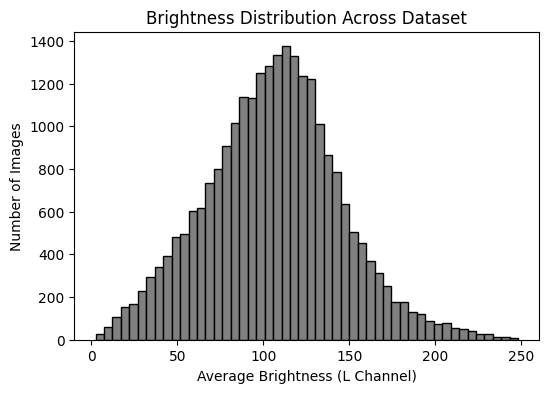

In [ ]:
# Compute brightness levels
avg_brightness = np.mean(gray_images, axis=(1, 2))

# Plot brightness distribution
plt.figure(figsize=(6, 4))
plt.hist(avg_brightness, bins=50, color="gray", edgecolor="black")
plt.xlabel("Average Brightness (L Channel)")
plt.ylabel("Number of Images")
plt.title("Brightness Distribution Across Dataset")
plt.show()

### Colorfulness distribution

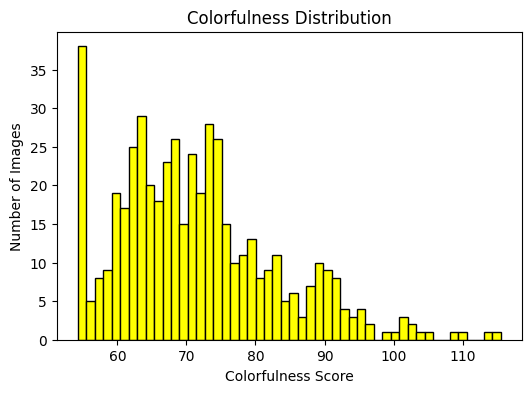

In [ ]:
import numpy as np
def compute_colorfulness(a, b):
    """Computes a simple colorfulness metric based on AB channels."""
    mean_a, mean_b = np.mean(a), np.mean(b)
    std_a, std_b = np.std(a), np.std(b)
    return np.sqrt(std_a**2 + std_b**2) + 0.3 * np.sqrt(mean_a**2 + mean_b**2)
random_indices = np.random.choice(ab1.shape[0], 500, replace=False)
colorfulness_scores = [compute_colorfulness(ab1[i, :, :, 0], ab1[i, :, :, 1]) for i in random_indices]
# Plot colorfulness distribution
plt.figure(figsize=(6, 4))
plt.hist(colorfulness_scores, bins=50, color="yellow", edgecolor="black")
plt.xlabel("Colorfulness Score")
plt.ylabel("Number of Images")
plt.title("Colorfulness Distribution")
plt.show()

* How much the colors vary (standard deviation)
* How far the colors are from neutral gray (mean)<br>
Higher values = more variety of colors

### LAB channels distribution

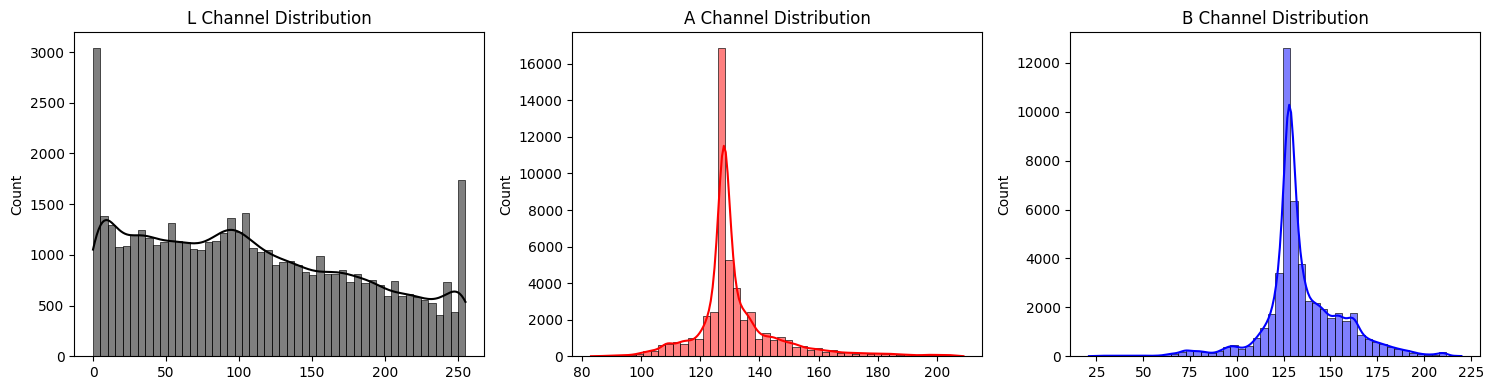

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load a subset of the data (e.g., first 50 images)
l_channel = np.load("image_colorization_data/l/gray_scale.npy")[:50]  # adjust this number
ab1 = np.load("image_colorization_data/ab/ab/ab1.npy")[:50]

# Flatten to pixels
l_pixels = l_channel.reshape(-1)
ab_pixels = ab1.reshape(-1, 2)

# Sample a fixed number of pixels
sample_size = 50000  # smaller number
indices = np.random.choice(len(l_pixels), sample_size, replace=False)

l_values = l_pixels[indices]
ab_sample = ab_pixels[indices]

# Split AB
a_values = ab_sample[:, 0]
b_values = ab_sample[:, 1]

# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(l_values, bins=50, kde=True, ax=ax[0], color="black")
ax[0].set_title("L Channel Distribution")

sns.histplot(a_values, bins=50, kde=True, ax=ax[1], color="red")
ax[1].set_title("A Channel Distribution")

sns.histplot(b_values, bins=50, kde=True, ax=ax[2], color="blue")
ax[2].set_title("B Channel Distribution")

plt.tight_layout()
plt.show()


### K-Means Clustering of AB Colors

Centroids (scaled): [[0.99642754 0.99302569]
 [1.28418609 1.34905682]
 [0.89196011 1.28693315]
 [1.16102794 0.65514368]
 [1.0964141  1.14561886]]


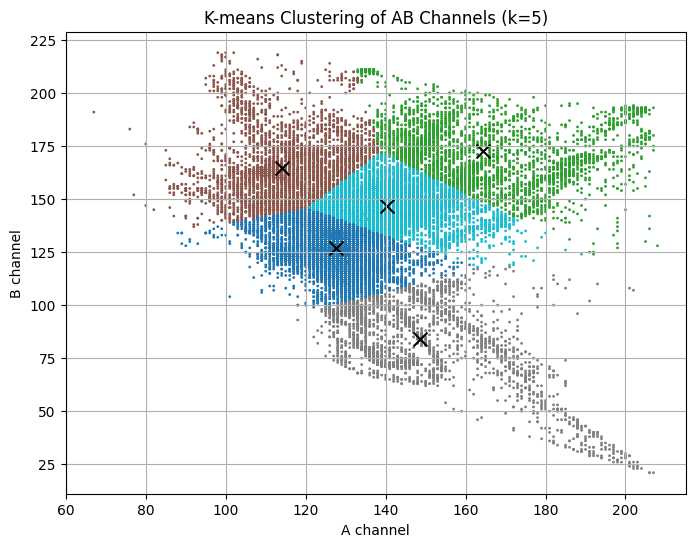

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ab_scaled = ab_sample / 128.0  # Scale to roughly [-1, 1] range

# Choose number of clusters
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(ab_scaled)
centroids = kmeans.cluster_centers_ #centroid is the average (mean) position of all the points in a cluster

print("Centroids (scaled):", centroids)
plt.figure(figsize=(8, 6))
plt.scatter(ab_sample[:, 0], ab_sample[:, 1], c=labels, cmap='tab10', s=1)
plt.scatter(centroids[:, 0] * 128, centroids[:, 1] * 128, color='black', marker='x', s=100)
plt.xlabel("A channel")
plt.ylabel("B channel")
plt.title(f"K-means Clustering of AB Channels (k={k})")
plt.grid(True)
plt.show()

# Data Preparation

Number of L and AB images should match. Our dataset is separated into l (25000 grayscale images), ab1 (10000), ab2 (10000) and ab3 (10000). Since this project is done in Google Colab, to avoid crashes we will first use 10000 of grayscale images with only ab1. This may lead to smaller accuracy.

In [ ]:
import numpy as np
l_channel = np.load("image_colorization_data/l/gray_scale.npy")[:10000]
ab = np.load("image_colorization_data/ab/ab/ab1.npy")
print("Gray image shape:", l_channel.shape)
print("AB image shape:", ab.shape)

Gray image shape: (10000, 224, 224)
AB image shape: (10000, 224, 224, 2)


In [ ]:
import numpy as np
import cv2

def resize_l_ab(l_array, ab_array, target_shape=(112, 112)):
    resized_l = []
    resized_ab = []

    for l_img, ab_img in zip(l_array, ab_array):
        l_resized = cv2.resize(l_img, target_shape, interpolation=cv2.INTER_AREA)
        ab_resized = cv2.resize(ab_img, target_shape, interpolation=cv2.INTER_AREA)
        resized_l.append(l_resized)
        resized_ab.append(ab_resized)

    return np.array(resized_l), np.array(resized_ab)
l_channel,ab = resize_l_ab(l_channel, ab, target_shape=(112, 112))

Resized the images from 224x224 to 112x112 to reduce RAM usage and avoid crashes.

### Filter Outliers

In [ ]:
# Remove over/under-exposed images (L channel)
mean_brightness = np.mean(l_channel, axis=(1, 2))
valid_indices = np.where((mean_brightness >= 20) & (mean_brightness <= 230))[0]
l_filtered = l_channel[valid_indices]
ab_filtered = ab[valid_indices]

# Remove low-colorfulness images (AB channels)
colorfulness = np.std(ab_filtered, axis=(1, 2, 3))
valid_indices = np.where(colorfulness > 10)[0]
l_filtered = l_filtered[valid_indices]
ab_filtered = ab_filtered[valid_indices]

### Balance Color Distribution

In [ ]:
import cv2
#  CLAHE on AB channels (applied per-image)
def apply_clahe(ab_image):
    a = ab_image[:, :, 0].astype(np.uint8)
    b = ab_image[:, :, 1].astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return np.stack([clahe.apply(a), clahe.apply(b)], axis=-1)
ab_enhanced = np.array([apply_clahe(img) for img in ab_filtered])

CLAHE enhances local contrast while preventing over-amplification of noise

### Data Augmentation

In [ ]:
#Random flips/rotations (applied to both L and AB)
augmented_l, augmented_ab = [], []
for l, ab in zip(l_filtered, ab_enhanced):
    if np.random.rand() > 0.5:
        l, ab = np.fliplr(l), np.fliplr(ab)  # Horizontal flip
    augmented_l.append(l)
    augmented_ab.append(ab)

l_processed = np.stack(augmented_l)
ab_processed = np.stack(augmented_ab)

Random flips and other augmentations increase data diversity, helping the model avoid overfitting and generalize better to unseen data.

### Normalize

In [ ]:
# Normalize L to [-1, 1] and AB to [-1, 1]
l_normalized = (l_processed / 127.5) - 1.0
ab_normalized = (ab_processed / 127.5) - 1.0

# Add channel dimension to L
l_normalized = np.expand_dims(l_normalized, axis=-1)

Normalization to [-1, 1] improves training efficiency and stability. <br>
Expanding the L channel ensures it fits the model’s expected input shape.

### Split

In [ ]:
from sklearn.model_selection import train_test_split
l_train, l_test, ab_train, ab_test = train_test_split(l_normalized, ab_normalized, test_size=0.1, random_state=42)
l_train, l_val, ab_train, ab_val = train_test_split(l_train, ab_train, test_size=0.1, random_state=42)